In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, sosfilt, sosfreqz, bilinear

$$
\alpha(\theta) = (1 + \frac{\alpha_{\text{min}}}{2}) + (1 - \frac{\alpha_{\text{min}}}{2}) \cos(\frac{\theta}{\theta_{\text{min}}}\pi)
$$

$$
\Delta T(\theta) = 
\begin{cases}
    -\frac{a}{c}\cos(\theta), & \text{if } 0 \le |\theta| < \frac{\pi}{2}\\
    \frac{a}{c}(|\theta|-\frac{\pi}{2}), & \text{if } \frac{\pi}{2} \le |\theta| < \pi \\
\end{cases}
$$

$$
\begin{align}
H_{HS}(\omega, \theta) 
&= \frac{1+j\frac{\alpha \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} \\
&= \frac{1+\frac{j \alpha a 2 \pi f}{c}}{1+\frac{j a 2 \pi f}{c}} \\
\end{align}
$$

$$
H_H(\omega, \theta) = \frac{1+j\frac{\alpha(\theta - \theta_{\text{ear}}) \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} e^{-j \omega T_d(\theta - \theta_{\text{ear}})}\\
$$

In [2]:
def compute_t(theta, a = 8.75, c = 34300):
    if 0 <= np.abs(theta) < np.pi / 2:
        return -a / c * np.cos(theta)
    elif np.pi / 2 <= np.abs(theta) < np.pi / 2:
        return a / c * (np.abs(theta) - np.pi / 2)
    else:
        return NotImplementedError

def compute_alpha(theta, alpha_min = 0.1, theta_min = 150):
    alpha = (1 + alpha_min * 0.5) + (1 - alpha_min * 0.5) * np.cos(theta * np.pi / theta_min)
    return alpha
    
def compute_transfer_function(theta, alpha_min = 0.1, theta_min = 150, a = 8.75, c = 34300):
    alpha = compute_alpha(theta, alpha_min, theta_min)
    
    f = np.arange(1, 1001) * c / (2 * np.pi * a)
    f = f / 10 # range from 0.1 to 100
    
    pole = alpha * a * np.pi * f / c
    zero = a * np.pi * f / c

    num = 1 + 1j * pole
    den = 1 + 1j * zero
    
    H = num / den
    
    return H

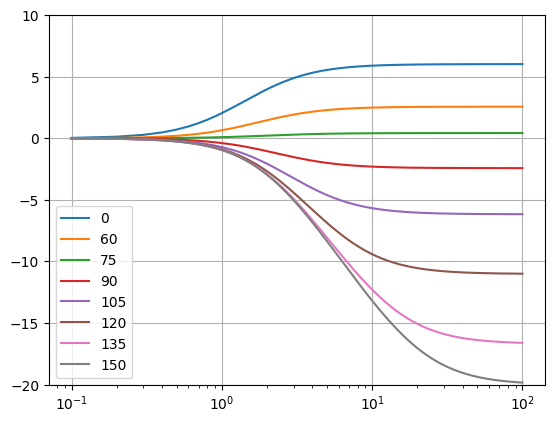

In [3]:
theta_array = [0, 60, 75, 90, 105, 120, 135, 150]
x = np.arange(1, 1001) / 10
for theta in theta_array:
    h = compute_transfer_function(theta)
    a = 20 * np.log10(np.abs(h))
    plt.plot(x, a, label = str(theta))

plt.grid(True)
plt.xscale('log')
plt.ylim(-20, 10)
plt.legend()
plt.show()